In [1]:
import random
import string
import re
import nltk
import torch

import copy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from nlp_project.notebook_utils import evaluate, split, save_scikit_model, load_scikit_model
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
# Saved Models path
models_path = "./models/T1_BoW_Models"

# Classification labels
labels = ["generated", "human"]

In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,you need to stop the engine and wait until it ...,generated
1,The Commission shall publish the report; an in...,generated
2,"I have not been tweeting a lot lately, but I d...",generated
3,I pass my exam and really thankgod for that bu...,human
4,The template will have 3 parts: a mustache sha...,human
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",human
33841,10. Article 13 of Council Directive 80/777/EEC...,human
33842,"Crying because I have to cry for you?. No. No,...",generated
33843,"However, it will continue to offer customers a...",generated


In [5]:
def preprocess(data, lower=True, vectorizer=None, fit=True):
    # Convert all text to lowercase
    if lower:
        data = [x.lower() for x in data]

    # Remove punctuation and reset multiple spaces to one
    punct_regex = re.compile("[" + string.punctuation + "\’'" + "]")
    whitespace_regex = re.compile(" ( )+")
    data = [whitespace_regex.sub(" ", punct_regex.sub(" ", x)) for x in data]
    
    # Vectorize
    if vectorizer:
        if fit:
            data = vectorizer.fit_transform(data)
        else:
            data = vectorizer.transform(data)
    
    return data

In [6]:
# CountVectorizer leads to comparable results
# Setting min_df < 4 leads to comparable results but with much more parameters

# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer(min_df=4, max_df=0.6)

In [7]:
x, y = df["text"], df["label"]
x_train, x_val, x_test, y_train, y_val, y_test = split(
    x, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train = preprocess(x_train, vectorizer=vectorizer)
x_test = preprocess(x_test, vectorizer=vectorizer, fit=False)

In [8]:
models = []
usecached = False

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Naive Bayes",
    "model": nb_clf,
    "usecached": usecached,
})

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Linear Regression",
    "model": lr_clf,
    "subsample": 0.7,
    "usecached": usecached,
})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "SVC",
    "model": svc_clf,
    "subsample": 0.7,
    "usecached": usecached,
})

# Decision Tree
dtree = DecisionTreeClassifier()
dtree_param = {
    "criterion": ["gini", "entropy"], 
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}
dtree_clf =  GridSearchCV(dtree, dtree_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Decision Tree",
    "model": dtree_clf,
    "usecached": usecached,
})

# Random Forest
rf = RandomForestClassifier()
rf_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
rf_clf =  GridSearchCV(rf, rf_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Random Forest",
    "model": rf_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

# Extra Trees
et = ExtraTreesClassifier()
et_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
et_clf =  GridSearchCV(et, et_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Extra Trees",
    "model": et_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

In [9]:
for model in models:
    if model["usecached"]:
        cache = load_scikit_model(models_path, model["name"])
        if cache:
            model["best"] = cache
            print(f"Restored model for {model['name']}")
            continue
        else:
            print(f"Couldn't restore model for {model['name']}")
            
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
            
    print(f"Training {model['name']}")        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")
    
    save_scikit_model(models_path, model["best"], model["name"])

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 0.1}
Best CV score: 0.7115897562845153
              precision    recall  f1-score   support

   generated       0.68      0.79      0.73      3360
       human       0.75      0.63      0.69      3409

    accuracy                           0.71      6769
   macro avg       0.72      0.71      0.71      6769
weighted avg       0.72      0.71      0.71      6769



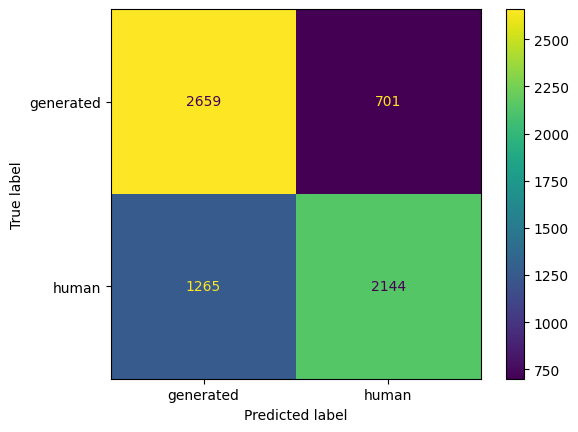

Linear Regression
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.7430441834028041
              precision    recall  f1-score   support

   generated       0.77      0.77      0.77      3360
       human       0.78      0.77      0.78      3409

    accuracy                           0.77      6769
   macro avg       0.77      0.77      0.77      6769
weighted avg       0.77      0.77      0.77      6769



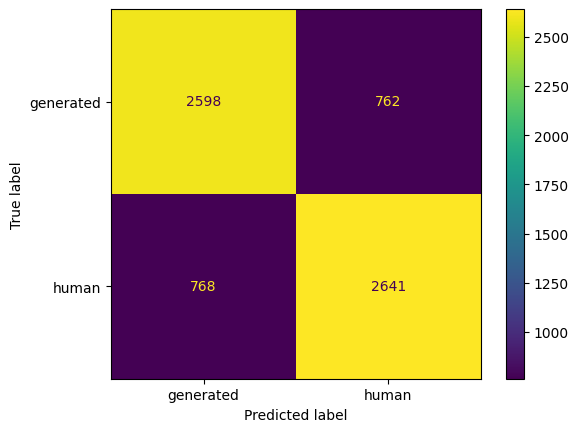

SVC
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best CV score: 0.7553579386131111
              precision    recall  f1-score   support

   generated       0.79      0.78      0.79      3360
       human       0.79      0.80      0.79      3409

    accuracy                           0.79      6769
   macro avg       0.79      0.79      0.79      6769
weighted avg       0.79      0.79      0.79      6769



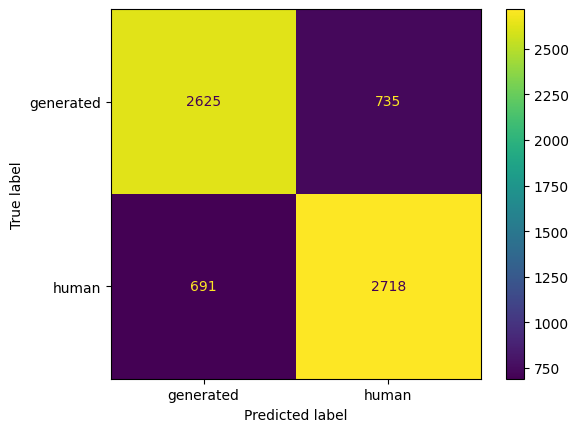

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.6969639834640632
              precision    recall  f1-score   support

   generated       0.69      0.68      0.68      3360
       human       0.69      0.70      0.69      3409

    accuracy                           0.69      6769
   macro avg       0.69      0.69      0.69      6769
weighted avg       0.69      0.69      0.69      6769



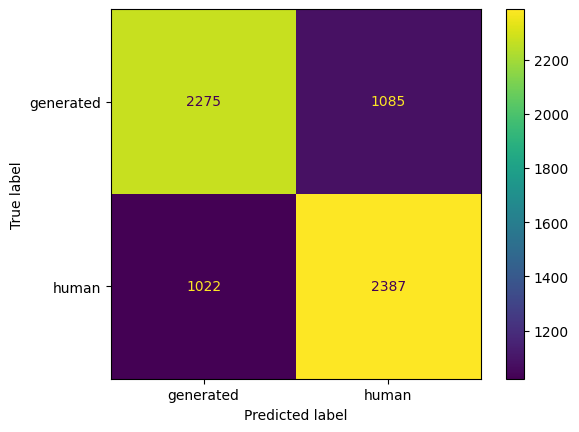

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7554016620498615
              precision    recall  f1-score   support

   generated       0.74      0.82      0.78      3360
       human       0.80      0.72      0.76      3409

    accuracy                           0.77      6769
   macro avg       0.77      0.77      0.77      6769
weighted avg       0.77      0.77      0.77      6769



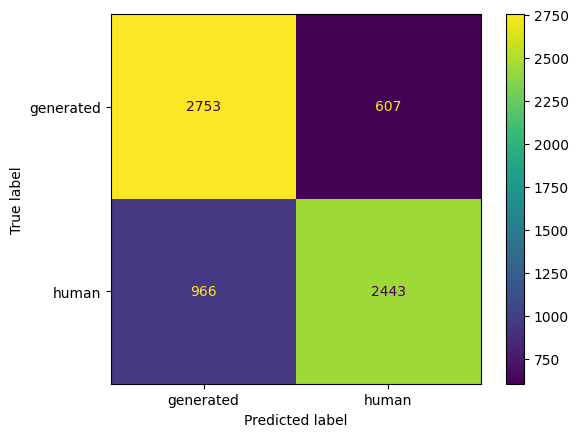

Extra Trees
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7665743305632502
              precision    recall  f1-score   support

   generated       0.74      0.84      0.79      3360
       human       0.82      0.71      0.76      3409

    accuracy                           0.78      6769
   macro avg       0.78      0.78      0.78      6769
weighted avg       0.78      0.78      0.78      6769



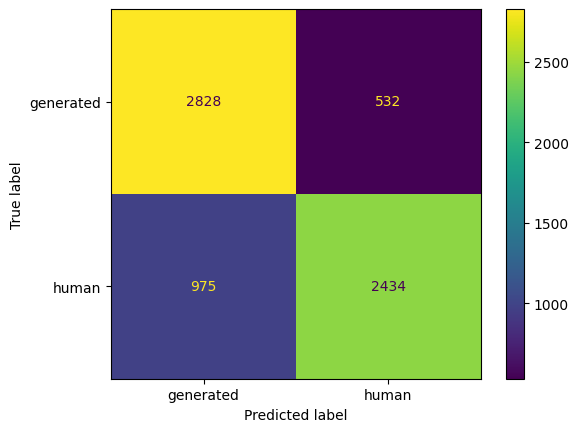

In [10]:
for model in models:
    print(f"{model['name']}")
    if hasattr(model["model"], "cv_results_"):
        print(f"Best parameters: {model['model'].best_params_}")
        print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [18]:
epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [19]:
y_ = LabelBinarizer().fit_transform(y).astype(float)

x_train, x_val, x_test, y_train, y_val, y_test = split(
    x, y_, test_size=0.1, val_size=0.1, seed=seed
)

x_train = preprocess(x_train, vectorizer=vectorizer)
x_val = preprocess(x_val, vectorizer=vectorizer, fit=False)
x_test = preprocess(x_test, vectorizer=vectorizer, fit=False)

In [21]:
ds_train = Data(x_train, y_train, x_type=np.float32)
ds_val = Data(x_val, y_val, x_type=np.float32)
ds_test = Data(x_test, y_test, x_type=np.float32)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [22]:
in_dim = x_train.shape[1]
out_dim = 1

In [37]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.6)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sig(self.l2(x))
        return x

In [38]:
nn_model = Network(in_dim, out_dim, binary_classifier=True, device=device)
loss = nn.BCELoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.01)
nn_model.compile(loss, optimizer)

In [39]:
earlystop = EarlyStopping(metric="val_acc", patience=10, baseline=0.7)
lradjust = AdaptLR(metric="val_acc", patience=5, factor=0.1)
callbacks = [earlystop, lradjust]

# nn_model.load_state_dict(torch.load(models_path + "NN Model"))
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=callbacks)

Epoch 1 -- loss: 0.0151153 acc: 0.7461590 val_loss: 0.0145875 val_acc: 0.7592319
Epoch 2 -- loss: 0.0109077 acc: 0.8366450 val_loss: 0.0146030 val_acc: 0.7775480
Epoch 3 -- loss: 0.0077746 acc: 0.8946669 val_loss: 0.0161961 val_acc: 0.7787297
Epoch 4 -- loss: 0.0050501 acc: 0.9353671 val_loss: 0.0184082 val_acc: 0.7645495
Epoch 5 -- loss: 0.0034244 acc: 0.9587458 val_loss: 0.0212900 val_acc: 0.7645495
Epoch 6 -- loss: 0.0025437 acc: 0.9695302 val_loss: 0.0260386 val_acc: 0.7607090
Epoch 7 -- loss: 0.0019938 acc: 0.9754395 val_loss: 0.0272972 val_acc: 0.7612998
Reducing lr to 0.0010
Epoch 8 -- loss: 0.0014873 acc: 0.9820136 val_loss: 0.0322371 val_acc: 0.7595273
Epoch 9 -- loss: 0.0010939 acc: 0.9866672 val_loss: 0.0339129 val_acc: 0.7612998
Epoch 10 -- loss: 0.0009874 acc: 0.9884399 val_loss: 0.0352568 val_acc: 0.7669129
Epoch 11 -- loss: 0.0008697 acc: 0.9894741 val_loss: 0.0333177 val_acc: 0.7610044
Epoch 12 -- loss: 0.0007933 acc: 0.9908406 val_loss: 0.0347516 val_acc: 0.7698671
Mod

{'acc': tensor(0.7595), 'loss': 0.01634086750394909}
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76      1680
         1.0       0.77      0.75      0.76      1704

    accuracy                           0.76      3384
   macro avg       0.76      0.76      0.76      3384
weighted avg       0.76      0.76      0.76      3384



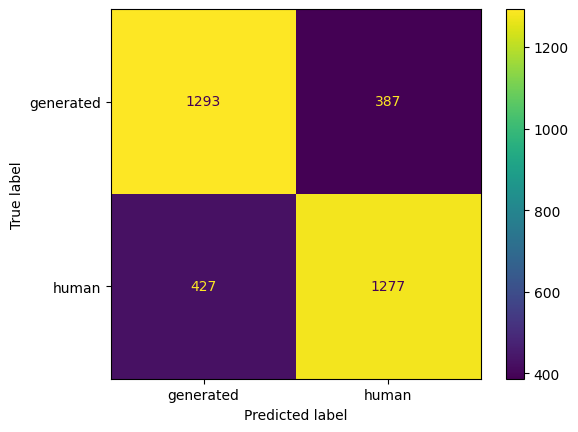

In [40]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

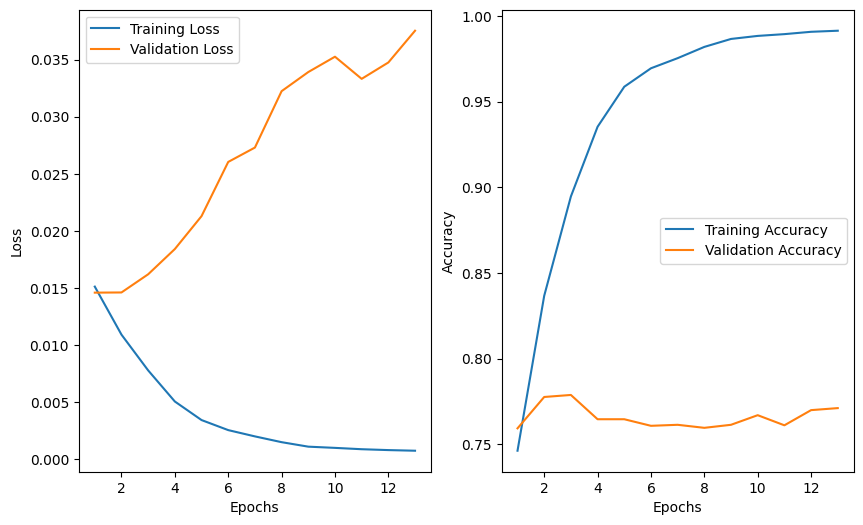

In [41]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

In [42]:
torch.save(nn_model.state_dict(), models_path + "/" + "NN Model")